In [19]:
# Modell TKA_Mo_240503_1_(MethT_V11)
# calculation of methanation chemical equilibrium by Gibbs energy minimization
# calculation of fugacity coefficients by Soave-Redlich-Kwong EOS or ideal gas assumption

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from ICIW_Plots import cyclers as ICIW_cyclers
import matplotlib
from TKA_Mo_240503_2_fugacity_coefficient_V2 import phi_Soave


def dfg(T):
    """
    function for determination of Gibbs free energy of formation of a species @ T from NIST-JANAF tables by a polynomic fit, range of validity: 0 - 6000 K

    :param T: temperature in K
    :return: Gibbs free energy of formation in J / mol
    """

    coeff = np.array([[ -4.4712899950965e-18, 7.69027397691646e-14, -4.83454740516897e-10, 2.06356409761266e-6, -4.28205970848287e-3, -3.93254377825293e2],  # CO2
                      [                    0,                    0,                     0,                   0,                    0,                   0],  # H2
                      [-1.19480733487367e-16, 2.05212901276465e-12,  -1.30585665138136e-8, 3.77285316328865e-5,  6.34019284855666e-2, -7.14155077436689e1],  # CH4
                      [                    0, 1.02813542552485e-13,  -1.46197827311474e-9, 7.46216055871485e-6,  4.27766908921636e-2, -2.41321516149705e2],  # H2O
                      [                    0,                    0,                     0, 1.60737136748171e-6, -9.02786221059026e-2, -1.11442697976118e2],  # CO
                      [                    0,                    0,                     0,                   0,                    0,                   0],  # C
                      [                    0,                    0,                     0,                   0,                    0,                   0],  # He
                      [                    0,                    0,                     0,                   0,                    0,                   0],  # Ar
                      [                    0,                    0,                     0,                   0,                    0,                   0]]) # N2

    T_poly = np.array([T**5, T**4, T**3, T**2, T, 1])

    res = np.matmul(T_poly, np.transpose(coeff)) * 1000
    return res


def g_T(n, T, p, type):
    """
    function for determination of the total Gibbs free energy to be minimized

    :param n: vector containing molar amounts of CO2, H2, CH4, H2O, CO, C, He, Ar and N2
    :param T: temperature in K
    :param p: pressure in bar
    :return: total Gibbs free energy in J / mol
    """

    for i in range(n.shape[0]):
        if n[i] <= 0:
            n[i] = 1e-20

    n_gas = np.delete(n, 5)   # array containing only the amounts of substance of gaseous species (CO2, H2, CH4, H2O, CO, He, Ar and N2) in mol
    #print('mole of gas', n_gas)
    n_sol = n[5] # array containing only the amounts of substance of solid species (C)
    #print('solid moles', n_sol)

    y_gas = n_gas / np.sum(n_gas) # array containing gas phase molar fractions of gaseous species
    x_sol = n_sol / np.sum(n_sol) # array containing solid phase molar fractions of solid species

    dfgi = dfg(T)              # Gibbs free energy of formation of all species in J / mol
    phii = np.ones_like(n_gas) # default array for fugacity coefficients of gaseous species in 1

    if type == 'ideal gas':
        phii = phii
    elif type == 'real gas':
        phii = phi_Soave(y_gas, T, p * 1e5) # function needs pressure in Pa and molar fractions in gas phase
    else:
        print('Please choose type of gas from given options: ideal gas or real gas')

    R  = 8.314 # universal gas constant in J / mol K
    p0 = 1 # standard pressure in bar

    res = np.dot(n, dfgi) + R * T * (np.dot(n_gas, np.log(phii * p * y_gas / p0)) + np.dot(n_sol, np.log(x_sol)))
    return res

Calculating the equilibrium composition ...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -96200.83362626548
            Iterations: 18
            Function evaluations: 175
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -96200.83362614023
            Iterations: 14
            Function evaluations: 150
            Gradient evaluations: 12
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -95996.43121535264
            Iterations: 16
            Function evaluations: 154
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -95997.08952675393
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current f

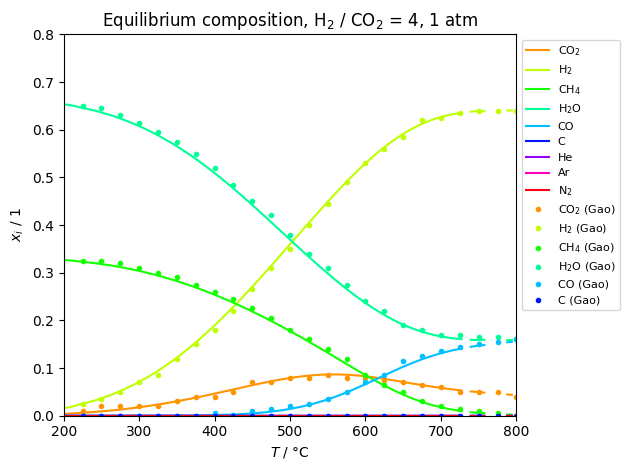

In [21]:
# setting constraints
def element_balance(n, n0):
    """
    function for checking the element balance as a constraint for the minimization

    :param n0: vector containing initial molar amounts of CO2, H2, CH4, H2O, CO, C, He, Ar and N2
    :return: residual -> 0
    """
    # element-species matrix (C, O, H, He, Ar, N)
    A = np.array([[1, 2, 0, 0, 0, 0],  # CO2
                  [0, 0, 2, 0, 0, 0],  # H2
                  [1, 0, 4, 0, 0, 0],  # CH4
                  [0, 1, 2, 0, 0, 0],  # H2O
                  [1, 1, 0, 0, 0, 0],  # CO
                  [1, 0, 0, 0, 0, 0],  # C
                  [0, 0, 0, 1, 0, 0],  # He
                  [0, 0, 0, 0, 1, 0],  # Ar
                  [0, 0, 0, 0, 0, 2]]) # N2
    res = np.matmul(n, A) - np.matmul(n0, A)
    return res

def calc_bounds(x0):
    n0      = x0 * 1    # initial molar amount in mol
    max_C   = n0[0] + n0[2] + n0[4] + n0[5]     # molar amount of carbon in the system in mol
    max_H   = 2 * n0[1] + 4 * n0[2] + 2 * n0[3] # molar amount of hydrogen in the system in mol
    max_O   = 2 * n0[0] + n0[3] + n0[4]         # molar amount of oxygen in the system in mol
    max_He  = n0[6]                             # molar amount of helium in the system in mol
    max_Ar  = n0[7]                             # molar amount of argon in the system in mol
    max_N   = n0[8]                             # molar amount of nitrogen in the system
    max_CO2 = min(max_C, 0.5 * max_O)           # maximum possible molar amount of CO2 in mol
    max_H2  = 0.5 * max_H                       # maximum possible molar amount of H2 in mol
    max_CH4 = min(max_C, 0.25 * max_H)          # maximum possible molar amount of CH4 in mol
    max_H2O = min(0.5 * max_H, max_O)           # maximum possible molar amount of H2O in mol
    max_CO  = min(max_C, max_O)                 # maximum possible molar amount of CO in mol
    max_N2  = 0.5 * max_N                       # maximum possible molar amount of N2 in mol

    bnds = ((0, max_CO2), (0, max_H2), (0, max_CH4), (0, max_H2O), (0, max_CO), (0, max_C), (0, max_He), (0, max_Ar), (0, np.inf))
    init = np.ones_like(n0)
    return n0,bnds,init

def equilibrium_composition_methanation_moles(T,p,x0,type='ideal gas'):
    '''
    Parameters
    ----------
        T: temperature in K
        p: pressure in Pa
        x0: inlet composition [CO2 H2 CH4 H2O CO C He Ar N2]
        type: type of gas, choose from 'ideal gas' or 'real gas'

    Returns
    -------
        x: equilibrium composition [CO2 H2 CH4 H2O CO C He Ar N2]

    '''
    print('Calculating the equilibrium composition ...')
    T = np.atleast_1d(T)
    p = np.atleast_1d(p)*1e-5 # in bar

    if x0.shape[0] < 9:
        for __ in range(9-len(x0)):
            x0 = np.append(x0,1e-20)

    n0,bnds,init = calc_bounds(x0)
    cons = {'type': 'eq', 'fun': element_balance, 'args': [n0]}

    x = np.ones([p.shape[0], T.shape[0], n0.shape[0]])
    n = np.ones([p.shape[0], T.shape[0], n0.shape[0]])
    success_store = np.full([p.shape[0], T.shape[0]],False,dtype=bool)

    once_false = 0
    twice_false = 0

    for pp in range(p.shape[0]):
        for TT in range(T.shape[0]):
            if round(np.sum(x0),5) != 1:
                ## Warning
                print(f'WARNING: Please check inlet composition! Sum of x_i is not one but {np.sum(x0)} !')

            else:
                sol = minimize(g_T, init, args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints = cons, options = {'disp': 'False', 'maxiter': 1000, 'ftol': 1e-12})
                success_store[pp,TT] = sol.success
                n[pp, TT]  = sol.x
                x[pp, TT] = sol.x / np.sum(sol.x)
                # print(sol.success)
                if round(np.sum(sol.x / np.sum(sol.x)), 5) != 1:
                    print('Error at ', p, 'bar and ', T, 'K!')
                if sol.success == False:
                    once_false += 1
                    sol = minimize(g_T, x[pp, TT - 1], args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints=cons, options={'disp': 'False', 'maxiter': 1000, 'ftol': 1e-5})
                    success_store[pp,TT] = sol.success
                    if sol.success == False:
                        twice_false += 1
                        sol = minimize(g_T, x[pp, TT - 2], args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints = cons, options = {'disp': 'False', 'maxiter': 1000, 'ftol': 1e-12})
                        success_store[pp,TT] = sol.success
                        x[pp, TT] = sol.x / np.sum(sol.x)
                    else:
                        n[pp, TT] = sol.x
                        x[pp, TT] = sol.x / np.sum(sol.x)

                    print(sol.success)
    
    print('\n---------------------------------')
    print('Equilibrium calculation finished.')
    if np.any(success_store):
        print('All successfull')
    else:
        print('Some unsuccessfull!')

    print(f'Once false: {once_false}')
    print(f'twice false: {twice_false}')

    # postprocessing - removing of not converged solutions
    T_corr   = np.ones([p.shape[0], T.shape[0]])
    non_conv = np.ones([p.shape[0]])


    for pp in range(p.shape[0]):
        T_corr[pp] = T

        for TT in range(T.shape[0]):
            if success_store[pp, TT] == False:
                T_corr[pp, TT] = np.nan
                n[pp, TT]  = np.nan
                x[pp, TT]  = np.nan

        # calculating degree of convergence
        non_conv[pp] = np.count_nonzero(np.isnan(T_corr[pp]))

    conv_deg = 1 - (np.sum(non_conv) / (T_corr.size))
    print('converged in ', np.round(conv_deg * 100, 1), '% of cases')
    # print(non_conv)
    print('---------------------------------\n')

    return x,n

##----------------------------------------------------------

if __name__ == '__main__':
    ## Test the model by verification with data from Gao

    ## validation (Gao 2012, https://doi.org/10.1039/C2RA00632D)
    p = np.array([1*1.01325])*1e5 # p in Pa
    T = np.linspace(200 + 273.15, 800 + 273.15, 100) # T in K
    type = 'ideal gas' # choose type of gas from 'ideal gas' and 'real gas'

    # Parameter
    x0 = np.empty(9)
    x0[0] = 0.2       # initial mole fraction of CO2
    x0[1] = 0.8-7e-20 # initial mole fraction of H2
    x0[2] = 1e-20     # initial mole fraction of CH4
    x0[3] = 1e-20     # initial mole fraction of H2O
    x0[4] = 1e-20     # initial mole fraction of CO
    x0[5] = 1e-20     # initial mole fraction of C
    x0[6] = 1e-20     # initial mole fraction of He
    x0[7] = 1e-20     # initial mole fraction of Ar
    x0[8] = 1e-20     # initial mole fraction of N2

    x,n = equilibrium_composition_methanation_moles(T,p,x0,'real gas')

    ## data import - validation data
    csv_data_Gao = pd.read_csv(r'data_Gao_CO2.csv',  # read csv file
                               sep = ';')

    ## convert read data into numpy array
    data_Gao         = csv_data_Gao.to_numpy()

    T_CO2_Gao        = data_Gao[:, 0]
    x_CO2_Gao        = data_Gao[:, 1:7]

    # plt.style.use('ICIWstyle')
    font = {'size': 10}
    matplotlib.rc('font', **font)

    ## CO2 methanation
    fig, axs = plt.subplots()
    for pp in range(p.shape[0]):
        cyc1 = ICIW_cyclers.ICIW_colormap_cycler('hsv', 9, start = 0.1, stop = 1)
        axs.set_prop_cycle(cyc1)
        axs.plot(T - 273.15,  x[pp, :, 0],     '-',                 label = 'CO$_2$')
        axs.plot(T - 273.15,  x[pp, :, 1],     '-',                 label = 'H$_2$')
        axs.plot(T - 273.15,  x[pp, :, 2],     '-',                 label = 'CH$_4$')
        axs.plot(T - 273.15,  x[pp, :, 3],     '-',                 label = 'H$_2$O')
        axs.plot(T - 273.15,  x[pp, :, 4],     '-',                 label = 'CO')
        axs.plot(T - 273.15,  x[pp, :, 5],     '-',                 label = 'C')
        axs.plot(T - 273.15,  x[pp, :, 6],     '-',                 label = 'He')
        axs.plot(T - 273.15,  x[pp, :, 7],     '-',                 label = 'Ar')
        axs.plot(T - 273.15,  x[pp, :, 8],     '-',                 label = 'N$_2$')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 0], 'o', markersize = 3, label = 'CO$_2$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 1], 'o', markersize = 3, label = 'H$_2$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 2], 'o', markersize = 3, label = 'CH$_4$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 3], 'o', markersize = 3, label = 'H$_2$O (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 4], 'o', markersize = 3, label = 'CO (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 5], 'o', markersize = 3, label = 'C (Gao)')
    axs.set_xlabel(r'$\mathit{T}$ / °C')
    axs.set_ylabel(r'$\mathit{x}_{\mathit{i}}$ / 1')
    axs.set_title('Equilibrium composition, H$_2$ / CO$_2$ = 4, 1 atm')
    axs.set_ylim(0, 0.8)
    axs.set_xlim(200, 800)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize = 8)
    plt.tight_layout()
    plt.show()

In [22]:


# setting constraints
def element_balance(n, n0):
    """
    function for checking the element balance as a constraint for the minimization

    :param n0: vector containing initial molar amounts of CO2, H2, CH4, H2O, CO, C, He, Ar and N2
    :return: residual -> 0
    """
    # element-species matrix (C, O, H, He, Ar, N)
    A = np.array([[1, 2, 0, 0, 0, 0],  # CO2
                  [0, 0, 2, 0, 0, 0],  # H2
                  [1, 0, 4, 0, 0, 0],  # CH4
                  [0, 1, 2, 0, 0, 0],  # H2O
                  [1, 1, 0, 0, 0, 0],  # CO
                  [1, 0, 0, 0, 0, 0],  # C
                  [0, 0, 0, 1, 0, 0],  # He
                  [0, 0, 0, 0, 1, 0],  # Ar
                  [0, 0, 0, 0, 0, 2]]) # N2
    res = np.matmul(n, A) - np.matmul(n0, A)
    return res

def calc_bounds(x0):
    n0      = x0 * 1    # initial molar amount in mol
    max_C   = n0[0] + n0[2] + n0[4] + n0[5]     # molar amount of carbon in the system in mol
    max_H   = 2 * n0[1] + 4 * n0[2] + 2 * n0[3] # molar amount of hydrogen in the system in mol
    max_O   = 2 * n0[0] + n0[3] + n0[4]         # molar amount of oxygen in the system in mol
    max_He  = n0[6]                             # molar amount of helium in the system in mol
    max_Ar  = n0[7]                             # molar amount of argon in the system in mol
    max_N   = n0[8]                             # molar amount of nitrogen in the system
    max_CO2 = min(max_C, 0.5 * max_O)           # maximum possible molar amount of CO2 in mol
    max_H2  = 0.5 * max_H                       # maximum possible molar amount of H2 in mol
    max_CH4 = min(max_C, 0.25 * max_H)          # maximum possible molar amount of CH4 in mol
    max_H2O = min(0.5 * max_H, max_O)           # maximum possible molar amount of H2O in mol
    max_CO  = min(max_C, max_O)                 # maximum possible molar amount of CO in mol
    max_N2  = 0.5 * max_N                       # maximum possible molar amount of N2 in mol

    bnds = ((0, max_CO2), (0, max_H2), (0, max_CH4), (0, max_H2O), (0, max_CO), (0, max_C), (0, max_He), (0, max_Ar), (0, np.inf))
    init = np.ones_like(n0)
    return n0,bnds,init

def equilibrium_composition_methanation_moles(T,p,x0,type='ideal gas'):
    '''
    Parameters
    ----------
        T: temperature in K
        p: pressure in Pa
        x0: inlet composition [CO2 H2 CH4 H2O CO C He Ar N2]
        type: type of gas, choose from 'ideal gas' or 'real gas'

    Returns
    -------
        x: equilibrium composition [CO2 H2 CH4 H2O CO C He Ar N2]

    '''
    print('Calculating the equilibrium composition ...')
    T = np.atleast_1d(T)
    p = np.atleast_1d(p)*1e-5 # in bar

    if x0.shape[0] < 9:
        for __ in range(9-len(x0)):
            x0 = np.append(x0,1e-20)

    n0,bnds,init = calc_bounds(x0)
    cons = {'type': 'eq', 'fun': element_balance, 'args': [n0]}

    x = np.ones([p.shape[0], T.shape[0], n0.shape[0]])
    n = np.ones([p.shape[0], T.shape[0], n0.shape[0]])
    success_store = np.full([p.shape[0], T.shape[0]],False,dtype=bool)

    once_false = 0
    twice_false = 0

    for pp in range(p.shape[0]):
        for TT in range(T.shape[0]):
            if round(np.sum(x0),5) != 1:
                ## Warning
                print(f'WARNING: Please check inlet composition! Sum of x_i is not one but {np.sum(x0)} !')

            else:
                sol = minimize(g_T, init, args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints = cons, options = {'disp': 'False', 'maxiter': 1000, 'ftol': 1e-12})
                success_store[pp,TT] = sol.success
                n[pp, TT]  = sol.x
                x[pp, TT] = sol.x / np.sum(sol.x)
                # print(sol.success)
                if round(np.sum(sol.x / np.sum(sol.x)), 5) != 1:
                    print('Error at ', p, 'bar and ', T, 'K!')
                if sol.success == False:
                    once_false += 1
                    sol = minimize(g_T, x[pp, TT - 1], args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints=cons, options={'disp': 'False', 'maxiter': 1000, 'ftol': 1e-5})
                    success_store[pp,TT] = sol.success
                    if sol.success == False:
                        twice_false += 1
                        sol = minimize(g_T, x[pp, TT - 2], args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints = cons, options = {'disp': 'False', 'maxiter': 1000, 'ftol': 1e-12})
                        success_store[pp,TT] = sol.success
                        x[pp, TT] = sol.x / np.sum(sol.x)
                    else:
                        n[pp, TT] = sol.x
                        x[pp, TT] = sol.x / np.sum(sol.x)

                    print(sol.success)
    
    print('\n---------------------------------')
    print('Equilibrium calculation finished.')
    if np.any(success_store):
        print('All successfull')
    else:
        print('Some unsuccessfull!')

    print(f'Once false: {once_false}')
    print(f'twice false: {twice_false}')

    # postprocessing - removing of not converged solutions
    T_corr   = np.ones([p.shape[0], T.shape[0]])
    non_conv = np.ones([p.shape[0]])


    for pp in range(p.shape[0]):
        T_corr[pp] = T

        for TT in range(T.shape[0]):
            if success_store[pp, TT] == False:
                T_corr[pp, TT] = np.nan
                n[pp, TT]  = np.nan
                x[pp, TT]  = np.nan

        # calculating degree of convergence
        non_conv[pp] = np.count_nonzero(np.isnan(T_corr[pp]))

    conv_deg = 1 - (np.sum(non_conv) / (T_corr.size))
    print('converged in ', np.round(conv_deg * 100, 1), '% of cases')
    # print(non_conv)
    print('---------------------------------\n')

    return x,n

In [23]:
# Parameter
x0 = np.empty(9)
x0[0] = 0.2       # initial mole fraction of CO2
x0[1] = 0.8-7e-20 # initial mole fraction of H2
x0[2] = 1e-20     # initial mole fraction of CH4
x0[3] = 1e-20     # initial mole fraction of H2O
x0[4] = 1e-20     # initial mole fraction of CO
x0[5] = 1e-20     # initial mole fraction of C
x0[6] = 1e-20     # initial mole fraction of He
x0[7] = 1e-20     # initial mole fraction of Ar
x0[8] = 1e-20     # initial mole fraction of N2

x,n = equilibrium_composition_methanation_moles(T,p,x0,'real gas')

Calculating the equilibrium composition ...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -96200.83362626548
            Iterations: 18
            Function evaluations: 175
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -96200.83362614023
            Iterations: 14
            Function evaluations: 150
            Gradient evaluations: 12
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -95996.43121535264
            Iterations: 16
            Function evaluations: 154
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -95997.08952675393
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current f

Calculating the equilibrium composition ...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -96200.83362626548
            Iterations: 18
            Function evaluations: 175
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -96200.83362614023
            Iterations: 14
            Function evaluations: 150
            Gradient evaluations: 12
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -95996.43121535264
            Iterations: 16
            Function evaluations: 154
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -95997.08952675393
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current f

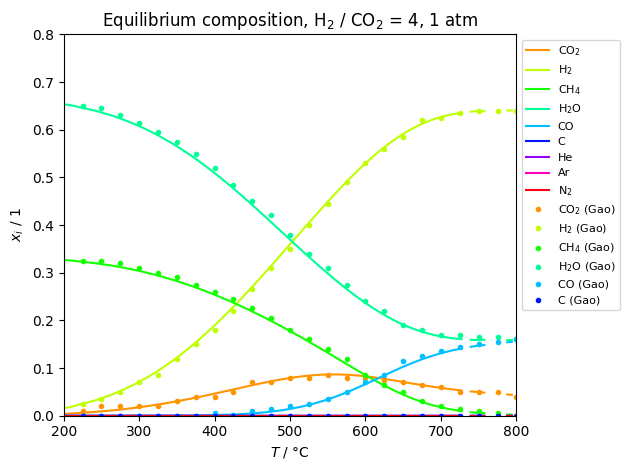

In [24]:

##----------------------------------------------------------

if __name__ == '__main__':
    ## Test the model by verification with data from Gao

    ## validation (Gao 2012, https://doi.org/10.1039/C2RA00632D)
    p = np.array([1*1.01325])*1e5 # p in Pa
    T = np.linspace(200 + 273.15, 800 + 273.15, 100) # T in K
    type = 'ideal gas' # choose type of gas from 'ideal gas' and 'real gas'

    # Parameter
    x0 = np.empty(9)
    x0[0] = 0.2       # initial mole fraction of CO2
    x0[1] = 0.8-7e-20 # initial mole fraction of H2
    x0[2] = 1e-20     # initial mole fraction of CH4
    x0[3] = 1e-20     # initial mole fraction of H2O
    x0[4] = 1e-20     # initial mole fraction of CO
    x0[5] = 1e-20     # initial mole fraction of C
    x0[6] = 1e-20     # initial mole fraction of He
    x0[7] = 1e-20     # initial mole fraction of Ar
    x0[8] = 1e-20     # initial mole fraction of N2

    x,n = equilibrium_composition_methanation_moles(T,p,x0,'real gas')

    ## data import - validation data
    csv_data_Gao = pd.read_csv(r'data_Gao_CO2.csv',  # read csv file
                               sep = ';')

    ## convert read data into numpy array
    data_Gao         = csv_data_Gao.to_numpy()

    T_CO2_Gao        = data_Gao[:, 0]
    x_CO2_Gao        = data_Gao[:, 1:7]

    # plt.style.use('ICIWstyle')
    font = {'size': 10}
    matplotlib.rc('font', **font)

    ## CO2 methanation
    fig, axs = plt.subplots()
    for pp in range(p.shape[0]):
        cyc1 = ICIW_cyclers.ICIW_colormap_cycler('hsv', 9, start = 0.1, stop = 1)
        axs.set_prop_cycle(cyc1)
        axs.plot(T - 273.15,  x[pp, :, 0],     '-',                 label = 'CO$_2$')
        axs.plot(T - 273.15,  x[pp, :, 1],     '-',                 label = 'H$_2$')
        axs.plot(T - 273.15,  x[pp, :, 2],     '-',                 label = 'CH$_4$')
        axs.plot(T - 273.15,  x[pp, :, 3],     '-',                 label = 'H$_2$O')
        axs.plot(T - 273.15,  x[pp, :, 4],     '-',                 label = 'CO')
        axs.plot(T - 273.15,  x[pp, :, 5],     '-',                 label = 'C')
        axs.plot(T - 273.15,  x[pp, :, 6],     '-',                 label = 'He')
        axs.plot(T - 273.15,  x[pp, :, 7],     '-',                 label = 'Ar')
        axs.plot(T - 273.15,  x[pp, :, 8],     '-',                 label = 'N$_2$')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 0], 'o', markersize = 3, label = 'CO$_2$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 1], 'o', markersize = 3, label = 'H$_2$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 2], 'o', markersize = 3, label = 'CH$_4$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 3], 'o', markersize = 3, label = 'H$_2$O (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 4], 'o', markersize = 3, label = 'CO (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 5], 'o', markersize = 3, label = 'C (Gao)')
    axs.set_xlabel(r'$\mathit{T}$ / °C')
    axs.set_ylabel(r'$\mathit{x}_{\mathit{i}}$ / 1')
    axs.set_title('Equilibrium composition, H$_2$ / CO$_2$ = 4, 1 atm')
    axs.set_ylim(0, 0.8)
    axs.set_xlim(200, 800)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize = 8)
    plt.tight_layout()
    plt.show()

Calculating the equilibrium composition ...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -96200.83362626548
            Iterations: 18
            Function evaluations: 175
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -96200.83362614023
            Iterations: 14
            Function evaluations: 150
            Gradient evaluations: 12
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -95996.43121535264
            Iterations: 16
            Function evaluations: 154
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -95997.08952675393
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3
True
Positive directional derivative for linesearch    (Exit mode 8)
            Current f

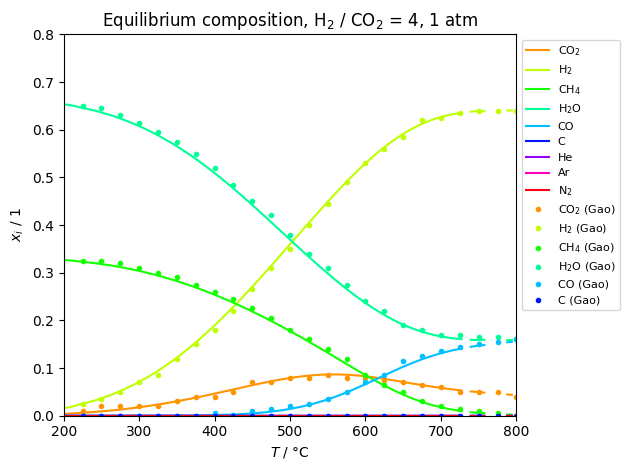

In [25]:


# setting constraints
def element_balance(n, n0):
    """
    function for checking the element balance as a constraint for the minimization

    :param n0: vector containing initial molar amounts of CO2, H2, CH4, H2O, CO, C, He, Ar and N2
    :return: residual -> 0
    """
    # element-species matrix (C, O, H, He, Ar, N)
    A = np.array([[1, 2, 0, 0, 0, 0],  # CO2
                  [0, 0, 2, 0, 0, 0],  # H2
                  [1, 0, 4, 0, 0, 0],  # CH4
                  [0, 1, 2, 0, 0, 0],  # H2O
                  [1, 1, 0, 0, 0, 0],  # CO
                  [1, 0, 0, 0, 0, 0],  # C
                  [0, 0, 0, 1, 0, 0],  # He
                  [0, 0, 0, 0, 1, 0],  # Ar
                  [0, 0, 0, 0, 0, 2]]) # N2
    res = np.matmul(n, A) - np.matmul(n0, A)
    return res

def calc_bounds(x0):
    n0      = x0 * 1    # initial molar amount in mol
    max_C   = n0[0] + n0[2] + n0[4] + n0[5]     # molar amount of carbon in the system in mol
    max_H   = 2 * n0[1] + 4 * n0[2] + 2 * n0[3] # molar amount of hydrogen in the system in mol
    max_O   = 2 * n0[0] + n0[3] + n0[4]         # molar amount of oxygen in the system in mol
    max_He  = n0[6]                             # molar amount of helium in the system in mol
    max_Ar  = n0[7]                             # molar amount of argon in the system in mol
    max_N   = n0[8]                             # molar amount of nitrogen in the system
    max_CO2 = min(max_C, 0.5 * max_O)           # maximum possible molar amount of CO2 in mol
    max_H2  = 0.5 * max_H                       # maximum possible molar amount of H2 in mol
    max_CH4 = min(max_C, 0.25 * max_H)          # maximum possible molar amount of CH4 in mol
    max_H2O = min(0.5 * max_H, max_O)           # maximum possible molar amount of H2O in mol
    max_CO  = min(max_C, max_O)                 # maximum possible molar amount of CO in mol
    max_N2  = 0.5 * max_N                       # maximum possible molar amount of N2 in mol

    bnds = ((0, max_CO2), (0, max_H2), (0, max_CH4), (0, max_H2O), (0, max_CO), (0, max_C), (0, max_He), (0, max_Ar), (0, np.inf))
    init = np.ones_like(n0)
    return n0,bnds,init

def equilibrium_composition_methanation_moles(T,p,x0,type='ideal gas'):
    '''
    Parameters
    ----------
        T: temperature in K
        p: pressure in Pa
        x0: inlet composition [CO2 H2 CH4 H2O CO C He Ar N2]
        type: type of gas, choose from 'ideal gas' or 'real gas'

    Returns
    -------
        x: equilibrium composition [CO2 H2 CH4 H2O CO C He Ar N2]

    '''
    print('Calculating the equilibrium composition ...')
    T = np.atleast_1d(T)
    p = np.atleast_1d(p)*1e-5 # in bar

    if x0.shape[0] < 9:
        for __ in range(9-len(x0)):
            x0 = np.append(x0,1e-20)

    n0,bnds,init = calc_bounds(x0)
    cons = {'type': 'eq', 'fun': element_balance, 'args': [n0]}

    x = np.ones([p.shape[0], T.shape[0], n0.shape[0]])
    n = np.ones([p.shape[0], T.shape[0], n0.shape[0]])
    success_store = np.full([p.shape[0], T.shape[0]],False,dtype=bool)

    once_false = 0
    twice_false = 0

    for pp in range(p.shape[0]):
        for TT in range(T.shape[0]):
            if round(np.sum(x0),5) != 1:
                ## Warning
                print(f'WARNING: Please check inlet composition! Sum of x_i is not one but {np.sum(x0)} !')

            else:
                sol = minimize(g_T, init, args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints = cons, options = {'disp': 'False', 'maxiter': 1000, 'ftol': 1e-12})
                success_store[pp,TT] = sol.success
                n[pp, TT]  = sol.x
                x[pp, TT] = sol.x / np.sum(sol.x)
                # print(sol.success)
                if round(np.sum(sol.x / np.sum(sol.x)), 5) != 1:
                    print('Error at ', p, 'bar and ', T, 'K!')
                if sol.success == False:
                    once_false += 1
                    sol = minimize(g_T, x[pp, TT - 1], args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints=cons, options={'disp': 'False', 'maxiter': 1000, 'ftol': 1e-5})
                    success_store[pp,TT] = sol.success
                    if sol.success == False:
                        twice_false += 1
                        sol = minimize(g_T, x[pp, TT - 2], args=(T[TT], p[pp], type), method='SLSQP', bounds=bnds, constraints = cons, options = {'disp': 'False', 'maxiter': 1000, 'ftol': 1e-12})
                        success_store[pp,TT] = sol.success
                        x[pp, TT] = sol.x / np.sum(sol.x)
                    else:
                        n[pp, TT] = sol.x
                        x[pp, TT] = sol.x / np.sum(sol.x)

                    print(sol.success)
    
    print('\n---------------------------------')
    print('Equilibrium calculation finished.')
    if np.any(success_store):
        print('All successfull')
    else:
        print('Some unsuccessfull!')

    print(f'Once false: {once_false}')
    print(f'twice false: {twice_false}')

    # postprocessing - removing of not converged solutions
    T_corr   = np.ones([p.shape[0], T.shape[0]])
    non_conv = np.ones([p.shape[0]])


    for pp in range(p.shape[0]):
        T_corr[pp] = T

        for TT in range(T.shape[0]):
            if success_store[pp, TT] == False:
                T_corr[pp, TT] = np.nan
                n[pp, TT]  = np.nan
                x[pp, TT]  = np.nan

        # calculating degree of convergence
        non_conv[pp] = np.count_nonzero(np.isnan(T_corr[pp]))

    conv_deg = 1 - (np.sum(non_conv) / (T_corr.size))
    print('converged in ', np.round(conv_deg * 100, 1), '% of cases')
    # print(non_conv)
    print('---------------------------------\n')

    return x,n

##----------------------------------------------------------

if __name__ == '__main__':
    ## Test the model by verification with data from Gao

    ## validation (Gao 2012, https://doi.org/10.1039/C2RA00632D)
    p = np.array([1*1.01325])*1e5 # p in Pa
    T = np.linspace(200 + 273.15, 800 + 273.15, 100) # T in K
    type = 'ideal gas' # choose type of gas from 'ideal gas' and 'real gas'

    # Parameter
    x0 = np.empty(9)
    x0[0] = 0.2       # initial mole fraction of CO2
    x0[1] = 0.8-7e-20 # initial mole fraction of H2
    x0[2] = 1e-20     # initial mole fraction of CH4
    x0[3] = 1e-20     # initial mole fraction of H2O
    x0[4] = 1e-20     # initial mole fraction of CO
    x0[5] = 1e-20     # initial mole fraction of C
    x0[6] = 1e-20     # initial mole fraction of He
    x0[7] = 1e-20     # initial mole fraction of Ar
    x0[8] = 1e-20     # initial mole fraction of N2

    x,n = equilibrium_composition_methanation_moles(T,p,x0,'real gas')

    ## data import - validation data
    csv_data_Gao = pd.read_csv(r'data_Gao_CO2.csv',  # read csv file
                               sep = ';')

    ## convert read data into numpy array
    data_Gao         = csv_data_Gao.to_numpy()

    T_CO2_Gao        = data_Gao[:, 0]
    x_CO2_Gao        = data_Gao[:, 1:7]

    # plt.style.use('ICIWstyle')
    font = {'size': 10}
    matplotlib.rc('font', **font)

    ## CO2 methanation
    fig, axs = plt.subplots()
    for pp in range(p.shape[0]):
        cyc1 = ICIW_cyclers.ICIW_colormap_cycler('hsv', 9, start = 0.1, stop = 1)
        axs.set_prop_cycle(cyc1)
        axs.plot(T - 273.15,  x[pp, :, 0],     '-',                 label = 'CO$_2$')
        axs.plot(T - 273.15,  x[pp, :, 1],     '-',                 label = 'H$_2$')
        axs.plot(T - 273.15,  x[pp, :, 2],     '-',                 label = 'CH$_4$')
        axs.plot(T - 273.15,  x[pp, :, 3],     '-',                 label = 'H$_2$O')
        axs.plot(T - 273.15,  x[pp, :, 4],     '-',                 label = 'CO')
        axs.plot(T - 273.15,  x[pp, :, 5],     '-',                 label = 'C')
        axs.plot(T - 273.15,  x[pp, :, 6],     '-',                 label = 'He')
        axs.plot(T - 273.15,  x[pp, :, 7],     '-',                 label = 'Ar')
        axs.plot(T - 273.15,  x[pp, :, 8],     '-',                 label = 'N$_2$')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 0], 'o', markersize = 3, label = 'CO$_2$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 1], 'o', markersize = 3, label = 'H$_2$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 2], 'o', markersize = 3, label = 'CH$_4$ (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 3], 'o', markersize = 3, label = 'H$_2$O (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 4], 'o', markersize = 3, label = 'CO (Gao)')
    axs.plot(T_CO2_Gao,   x_CO2_Gao[:, 5], 'o', markersize = 3, label = 'C (Gao)')
    axs.set_xlabel(r'$\mathit{T}$ / °C')
    axs.set_ylabel(r'$\mathit{x}_{\mathit{i}}$ / 1')
    axs.set_title('Equilibrium composition, H$_2$ / CO$_2$ = 4, 1 atm')
    axs.set_ylim(0, 0.8)
    axs.set_xlim(200, 800)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize = 8)
    plt.tight_layout()
    plt.show()